In [1]:
import os
import time

import cv2
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

First, let's organize our data set and display some images

In [2]:
class SiameseDataLoader():
    def __init__(self, data_path, batch_size=16, image_size=200):
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.file_paths = []
        self.labels = []
        for root, directories, filenames in os.walk(data_path):
            # Only get images (in subfolders)
            if not root == data_path:
                for filename in filenames:
                    self.file_paths.append(os.path.join(root, filename))
                    self.labels.append(root)
                    
        self.n_data_points = len(self.file_paths)
                    
    def get_triplets(self):

        random_ordering = np.random.permutation(self.n_data_points)
        lower = 0
        upper = self.batch_size
        
        while lower < self.n_data_points:
            anchors = []
            positives = []
            negatives = []
            
            for anchor in random_ordering[lower:upper]:
                anchor_file_path = self.file_paths[anchor]
                anchor_label = self.labels[anchor]
                
                positive = np.random.choice(self.n_data_points)
                while self.labels[positive] != anchor_label or positive == anchor:
                    positive = np.random.choice(self.n_data_points)

                positive_file_path = self.file_paths[positive]
                assert self.labels[positive] == anchor_label
                assert positive != anchor_label
                
                negative = np.random.choice(self.n_data_points)
                while self.labels[negative] == anchor_label:
                    negative = np.random.choice(self.n_data_points)

                negative_file_path = self.file_paths[negative]
                assert self.labels[negative] != anchor_label
                
                anchors.append(self.get_image(anchor_file_path))
                positives.append(self.get_image(positive_file_path))
                negatives.append(self.get_image(negative_file_path))
                
                
            lower, upper = upper, upper + self.batch_size
            
            yield anchors, positives, negatives
            
    def get_image(self, file_path):
        image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
        
        h, w = image.shape[0], image.shape[1]
        
        s = min(h, w)
        h_mid = h // 2
        w_mid = w // 2
        margin = s // 2
        
        image = image[h_mid - margin:h_mid + margin, w_mid - margin:w_mid + margin]
        
        return cv2.resize(image, (self.image_size, self.image_size))

In [3]:
train_path = './training'
valid_path = './validation'
train_set = SiameseDataLoader(train_path, batch_size=4)
valid_set = SiameseDataLoader(valid_path, batch_size=4)

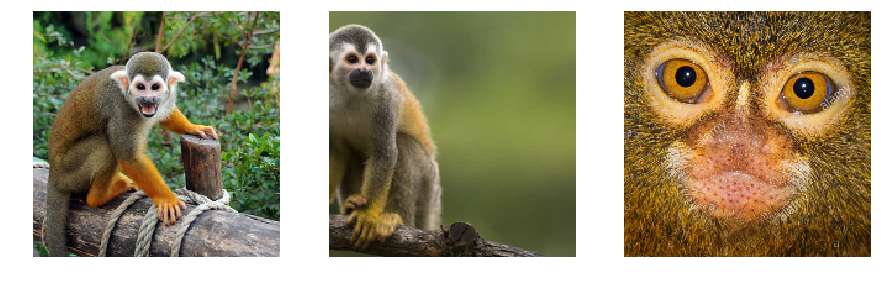

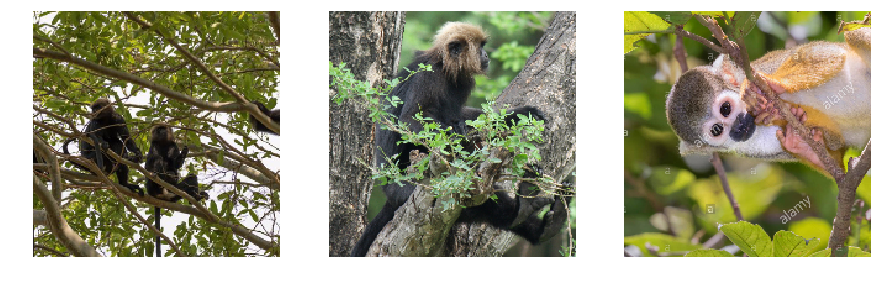

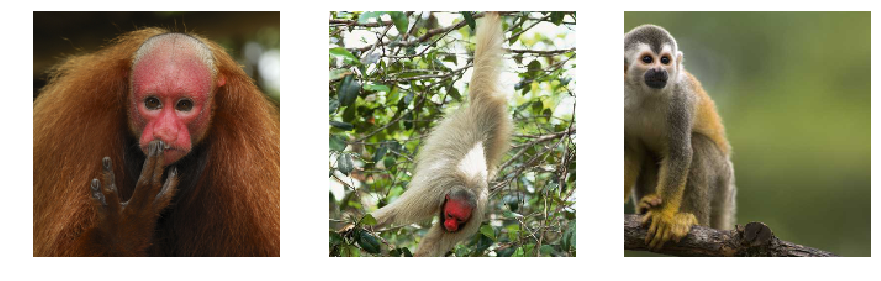

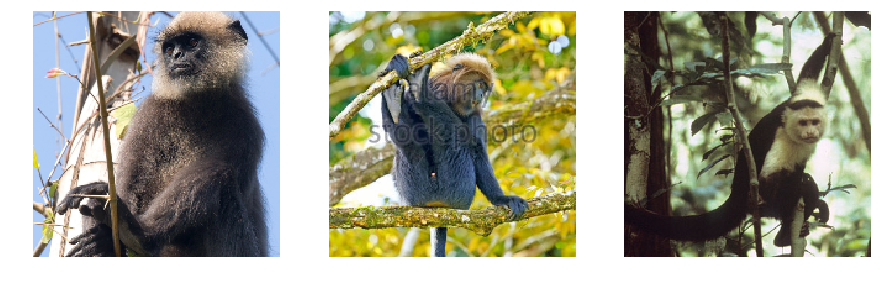

In [4]:
# Display some images
for anchor, positive, negative in list(zip(*next(train_set.get_triplets())))[:4]:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(anchor)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(positive)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(negative)
    plt.axis('off')
    
    plt.show()

In [5]:
# Now, let's create our Siamese Network

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
         
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.ReflectionPad2d(3)
        )

        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5),
            nn.ReflectionPad2d(2)
        )
        self.bn2 = nn.BatchNorm2d(16)
       
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReflectionPad2d(1)
        )
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReflectionPad2d(1)
        )
        self.bn4 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 51 * 51, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True)
        )
        
    def forward_once(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        
        return x        
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * 0.5 * torch.pow(euclidean_distance, 2) + \
                            label * 0.5 * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [7]:
RUN_NAME = "test-4conv2fc"
LEARNING_RATE = 1e-8
N_EPOCHS = 15
WEIGHT_DECAY = 5e-3

siamese_net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [8]:
loss_history = []
for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch}')
    epoch_loss = 0
    for anchors, positives, negatives in train_set.get_triplets():
        a_tensor = torch.tensor([np.transpose(a, (2, 0, 1)) for a in anchors]).type_as(torch.FloatTensor())
        p_tensor = torch.tensor([np.transpose(p, (2, 0, 1)) for p in positives]).type_as(torch.FloatTensor())
        n_tensor = torch.tensor([np.transpose(n, (2, 0, 1)) for n in negatives]).type_as(torch.FloatTensor())
        
        output1, output2 = siamese_net(a_tensor, p_tensor)
        label = Variable(torch.ones(a_tensor.shape[0]))
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss += loss_contrastive.item() * a_tensor.shape[0]

        output1, output2 = siamese_net(a_tensor, n_tensor)
        label = Variable(torch.zeros(a_tensor.shape[0]))
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss += loss_contrastive.item() * a_tensor.shape[0]
    epoch_loss = epoch_loss / train_set.n_data_points
    print(f'Epoch loss: {epoch_loss}')
    loss_history.append(epoch_loss)

Epoch: 0
Epoch loss: 3.1730235504539506
Epoch: 1
Epoch loss: 1.1817971894971626
Epoch: 2
Epoch loss: 0.5050303047317921
Epoch: 3
Epoch loss: 0.3252138392541741
Epoch: 4
Epoch loss: 0.2892952942185932
Epoch: 5
Epoch loss: 0.2969128716268826
Epoch: 6
Epoch loss: 0.28470397295467625
Epoch: 7
Epoch loss: 0.27940119292675253
Epoch: 8
Epoch loss: 0.28360850001619164
Epoch: 9
Epoch loss: 0.27756290471618944
Epoch: 10
Epoch loss: 0.2843123778347978
Epoch: 11
Epoch loss: 0.27059073610492523
Epoch: 12
Epoch loss: 0.2824285131470319
Epoch: 13
Epoch loss: 0.2718226802696513
Epoch: 14
Epoch loss: 0.2743680610682795


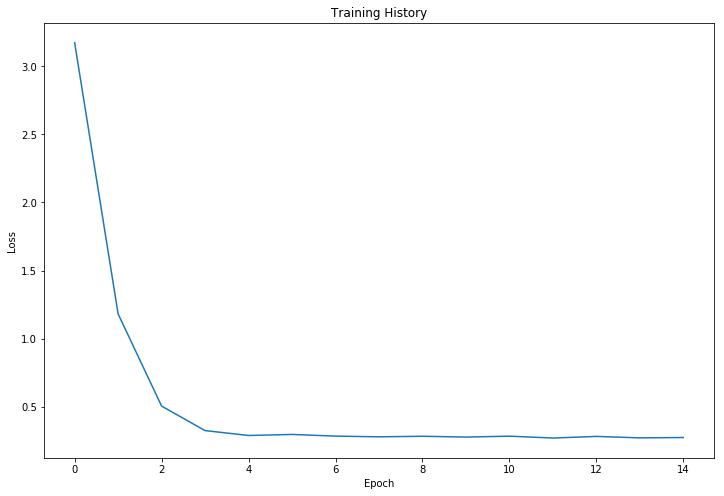

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(len(loss_history))), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()

In [14]:
with open("log.txt", "a+") as f:
    f.write(f'{RUN_NAME}, {LEARNING_RATE}, {N_EPOCHS}, {WEIGHT_DECAY}, {loss_history}\n')

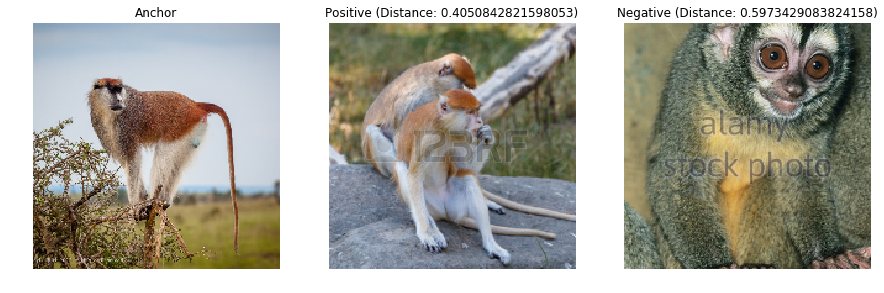

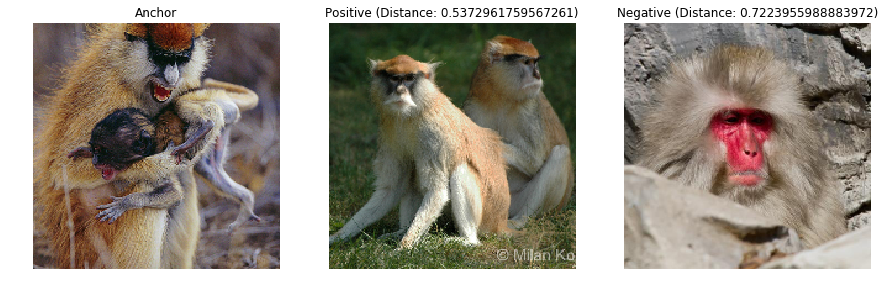

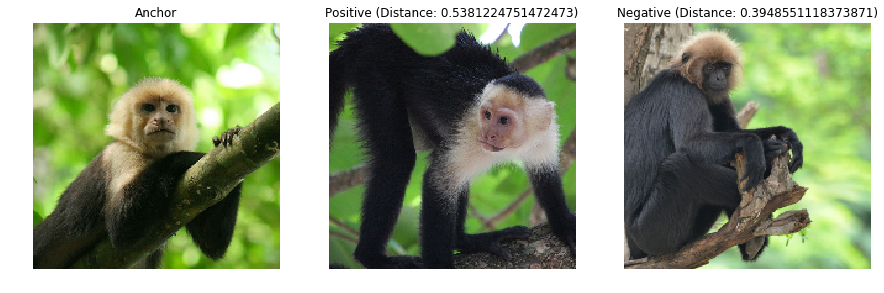

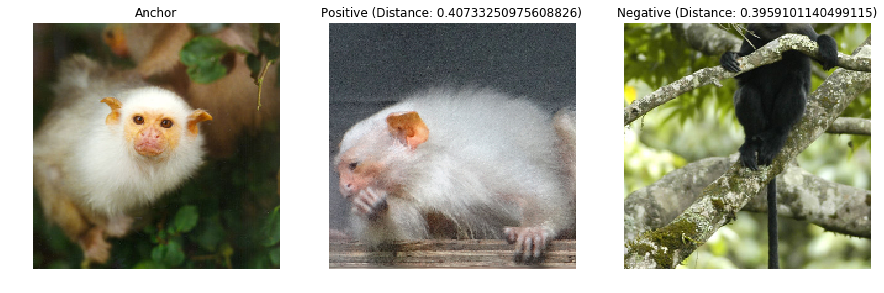

In [10]:
anchors, positives, negatives =  next(train_set.get_triplets())
a_tensor = torch.tensor([np.transpose(a, (2, 0, 1)) for a in anchors]).type_as(torch.FloatTensor())
p_tensor = torch.tensor([np.transpose(p, (2, 0, 1)) for p in positives]).type_as(torch.FloatTensor())
n_tensor = torch.tensor([np.transpose(n, (2, 0, 1)) for n in negatives]).type_as(torch.FloatTensor())

output1, output2 = siamese_net(a_tensor, p_tensor)
positive_distances = F.pairwise_distance(output1, output2)

output1, output2 = siamese_net(a_tensor, n_tensor)
negative_distances = F.pairwise_distance(output1, output2)

for i in range(a_tensor.shape[0]):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(anchors[i])
    plt.axis('off')
    plt.title('Anchor')

    plt.subplot(1, 3, 2)
    plt.imshow(positives[i])
    plt.axis('off')
    plt.title(f'Positive (Distance: {positive_distances[i]})')
    
    plt.subplot(1, 3, 3)
    plt.imshow(negatives[i])
    plt.axis('off')
    plt.title(f'Negative (Distance: {negative_distances[i]})')
    plt.show()

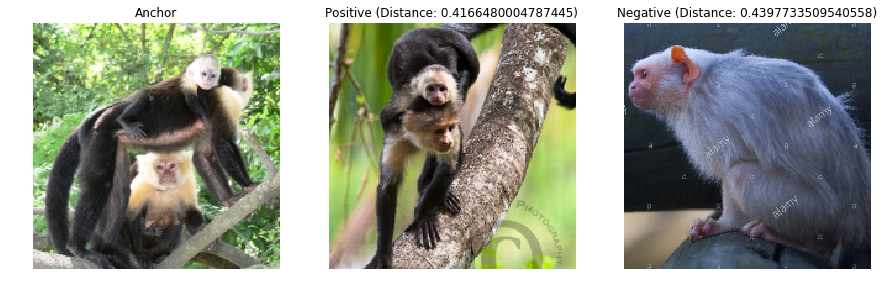

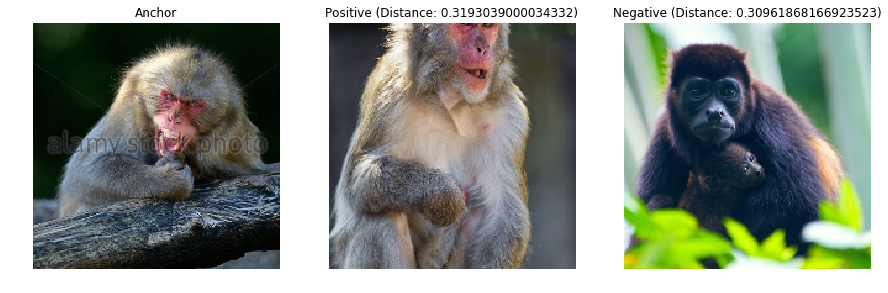

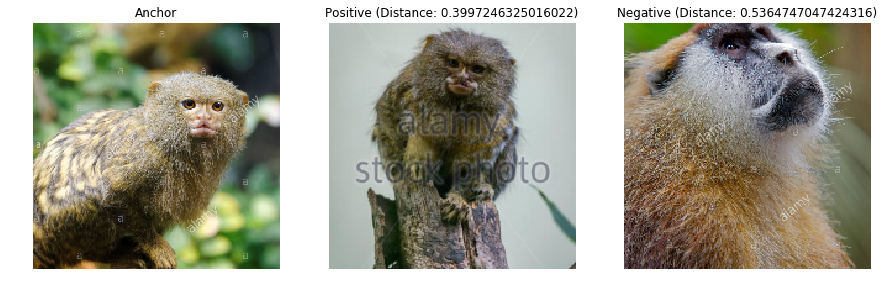

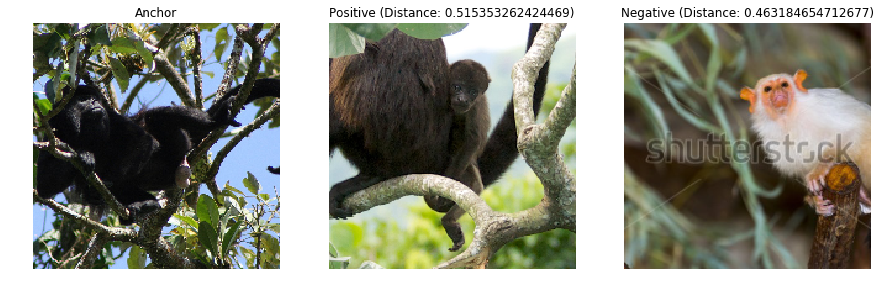

In [11]:
anchors, positives, negatives =  next(valid_set.get_triplets())
a_tensor = torch.tensor([np.transpose(a, (2, 0, 1)) for a in anchors]).type_as(torch.FloatTensor())
p_tensor = torch.tensor([np.transpose(p, (2, 0, 1)) for p in positives]).type_as(torch.FloatTensor())
n_tensor = torch.tensor([np.transpose(n, (2, 0, 1)) for n in negatives]).type_as(torch.FloatTensor())

output1, output2 = siamese_net(a_tensor, p_tensor)
positive_distances = F.pairwise_distance(output1, output2)

output1, output2 = siamese_net(a_tensor, n_tensor)
negative_distances = F.pairwise_distance(output1, output2)

for i in range(a_tensor.shape[0]):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(anchors[i])
    plt.axis('off')
    plt.title('Anchor')

    plt.subplot(1, 3, 2)
    plt.imshow(positives[i])
    plt.axis('off')
    plt.title(f'Positive (Distance: {positive_distances[i]})')
    
    plt.subplot(1, 3, 3)
    plt.imshow(negatives[i])
    plt.axis('off')
    plt.title(f'Negative (Distance: {negative_distances[i]})')
    plt.show()